# Predicting housing prices based on parameters

Our project's goal is to create a model that would predict the price of houses in the US.
We got our dataset from [USA Real Estate Dataset](https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset)
created by **Ahmed Shahriar Sakib** in 2024. The dataset contains 12 columns and more than
2.2M records.

The following work will cover most of the processing done by us. From dataset preprocessing
and displaying dataset statistics, to model training.

## Document information
- Authors: Hung Do and Hamza Zakai
- Date: 09/2024
- Class: Machine Learning @ Aalto University

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!ln -s "/gdrive/MyDrive/Colab Notebooks" "/content/cn"

Mounted at /gdrive


In [ ]:
#pip install --upgrade scikit-learn cython


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier


from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_csv("/content/cn/realtor-data.csv")
df.head()

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaN


In [ ]:
# get column data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226382 entries, 0 to 2226381
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   brokered_by     float64
 1   status          object 
 2   price           float64
 3   bed             float64
 4   bath            float64
 5   acre_lot        float64
 6   street          float64
 7   city            object 
 8   state           object 
 9   zip_code        float64
 10  house_size      float64
 11  prev_sold_date  object 
dtypes: float64(8), object(4)
memory usage: 203.8+ MB


In [ ]:
# number of missing values (NaN) for each column
df.isna().sum()

,0
brokered_by,4533
status,0
price,1541
bed,481317
bath,511771
acre_lot,325589
street,10866
city,1407
state,8
zip_code,299


## Dataset preprocessing

Before we start working with the dataset, we need to do the analysis and edit the dataset
to the desired format. The dataset contains lots of missing values (land size), some columns
were loaded with a wrong dataset (`zip_code` is not a `float64` but a string) and more.

In this section we will focus on two things:
1) Either repair missing values or remove items if not possible,
2) Change the column data types to reduce the size of the DataFrame.

#### Repair or remove records with missing values

In [ ]:
# drop rows with missing values
df = df.dropna(subset=['price', 'state', 'zip_code', 'house_size', 'acre_lot'])
df = df.loc[(df['bed'].notna()) & (df['bath'].notna())].reset_index(drop=True)

# fix some data
df['brokered_by'] = df['brokered_by'].fillna(-1)
df['street'] = df['street'].fillna(-1)
df['prev_sold'] = df['prev_sold_date'].notna()
df['zip_code'] = df['zip_code'].astype(int).astype(str)
df['zip_code'] = df['zip_code'].str.pad(5, 'left', '0')
df

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date,prev_sold
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,00601,920.0,NaN,False
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,00601,1527.0,NaN,False
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,00795,748.0,NaN,False
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,00731,1800.0,NaN,False
4,103378.0,for_sale,179000.0,4.0,3.0,0.46,1850806.0,San Sebastian,Puerto Rico,00612,2520.0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1360622,23009.0,sold,359900.0,4.0,2.0,0.33,353094.0,Richland,Washington,99354,3600.0,2022-03-25,True
1360623,18208.0,sold,350000.0,3.0,2.0,0.10,1062149.0,Richland,Washington,99354,1616.0,2022-03-25,True
1360624,76856.0,sold,440000.0,6.0,3.0,0.50,405677.0,Richland,Washington,99354,3200.0,2022-03-24,True
1360625,53618.0,sold,179900.0,2.0,1.0,0.09,761379.0,Richland,Washington,99354,933.0,2022-03-24,True


#### Optimize data types

In [ ]:
df['brokered_by'] = df['brokered_by'].astype(int)
df['for_sale'] = df['status'].astype('category').cat.rename_categories({'sold': 0, 'for_sale': 1})
df['bed'] = df['bed'].astype(int)
df['bath'] = df['bath'].astype(int)
df['street'] = df['street'].astype(int)
df['state'] = df['state'].astype('category')
df['city'] = df['city'].astype('category')
usa_state_mapping = {st:i for i, st in enumerate(df['state'].unique())}
df['state'] = df['state'].cat.rename_categories(usa_state_mapping)
usa_city_mapping = {st:i for i, st in enumerate(df['city'].unique())}
df['city'] = df['city'].cat.rename_categories(usa_city_mapping)
df = df.drop(['status', 'prev_sold_date'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1360627 entries, 0 to 1360626
Data columns (total 12 columns):
 #   Column       Non-Null Count    Dtype   
---  ------       --------------    -----   
 0   brokered_by  1360627 non-null  int64   
 1   price        1360627 non-null  float64 
 2   bed          1360627 non-null  int64   
 3   bath         1360627 non-null  int64   
 4   acre_lot     1360627 non-null  float64 
 5   street       1360627 non-null  int64   
 6   city         1360347 non-null  category
 7   state        1360627 non-null  category
 8   zip_code     1360627 non-null  object  
 9   house_size   1360627 non-null  float64 
 10  prev_sold    1360627 non-null  bool    
 11  for_sale     1360627 non-null  category
dtypes: bool(1), category(3), float64(3), int64(4), object(1)
memory usage: 90.2+ MB


<Axes: title={'center': 'Correlation of the labels'}>

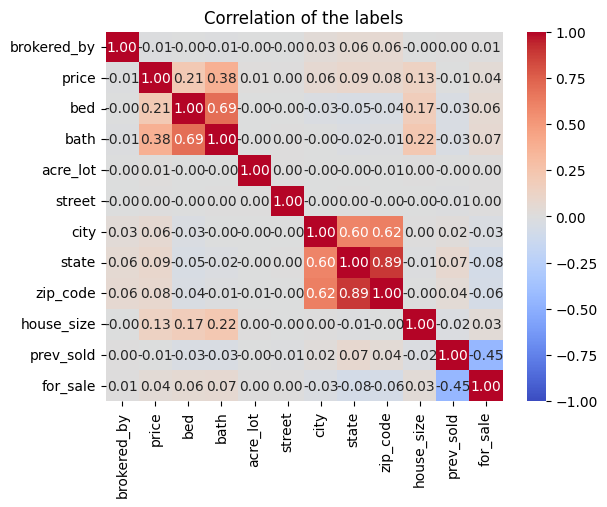

In [ ]:
_g = sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="coolwarm")
_g.set_title("Correlation of the labels")
_g

We manage to reduce the size of the dataset from **203.8MB+** to **86.9MB**.

In [ ]:
df = df.drop(['city', 'zip_code', 'bath'], axis=1) # dropped as its tied to the zip code

## Statistics

Now we perform some statistical analysis on the given dataset. In this section we will look
at the distribution of some features. In the second part of the section we will remove outliers
for better model training.

In [ ]:
df[list(set(df.columns) - {'brokered_by', 'street'})].describe()

,price,bed,house_size,acre_lot
count,1.360627e+06,1.360627e+06,1.360627e+06,1.360627e+06
mean,5.734360e+05,3.386161e+00,2.120834e+03,1.274836e+01
std,1.226337e+06,1.428047e+00,4.175516e+03,7.996613e+02
min,0.000000e+00,1.000000e+00,1.000000e+02,0.000000e+00
25%,2.390000e+05,3.000000e+00,1.360000e+03,1.400000e-01
50%,3.790000e+05,3.000000e+00,1.812000e+03,2.100000e-01
75%,6.000000e+05,4.000000e+00,2.478000e+03,4.600000e-01
max,5.150000e+08,4.440000e+02,1.560780e+06,1.000000e+05


In [ ]:
df_new = df.copy(deep=True)

In [ ]:
df_new.sort_values('price', ascending=False).head(10)[['price', 'state', 'bed']]
# df_new.sort_values('bath')


,price,state,bed
673441,515000000.0,50,2
51010,169000000.0,5,6
651116,165000000.0,50,14
684434,160000000.0,50,10
236323,150000000.0,25,12
243971,115000000.0,25,7
684446,109000000.0,50,3
243123,106000000.0,25,9
651555,100000000.0,50,11
693298,100000000.0,50,5


### Broker/agency statistics

In [ ]:
# number of brokers/agencies
print("Number of brokers: ", len(df['brokered_by'].unique()))

# top brokers
print("Top brokers: ")
print(
    df.groupby('brokered_by') \
        .count() \
        .sort_values('price', ascending=False)['price'] \
        .head(10) \
        .to_string(header=False)
)

Number of brokers:  91327
Top brokers: 
22611     29790
16829     18002
53016     15341
30807      5725
33714      4806
23592      4624
84534      4243
79221      4237
109978     4208
70677      3778


### Prices

When analyzing the prices of properties we can see that there are plenty of outliers.
The range is so huge that we cannot see the majority of the houses in the graph. Some properties
cost more than 500 million USD. We will have to reduce the dataset later by removing some outliers
for better model training.

In [ ]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


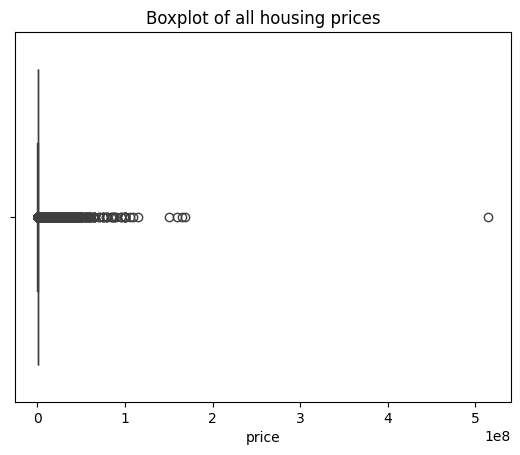

In [ ]:
fig, ax = plt.subplots(1, 1)
g = sns.boxplot(df.loc[df['price'] < 1e10], x='price', ax=ax)
_ = g.set(title="Boxplot of all housing prices")

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


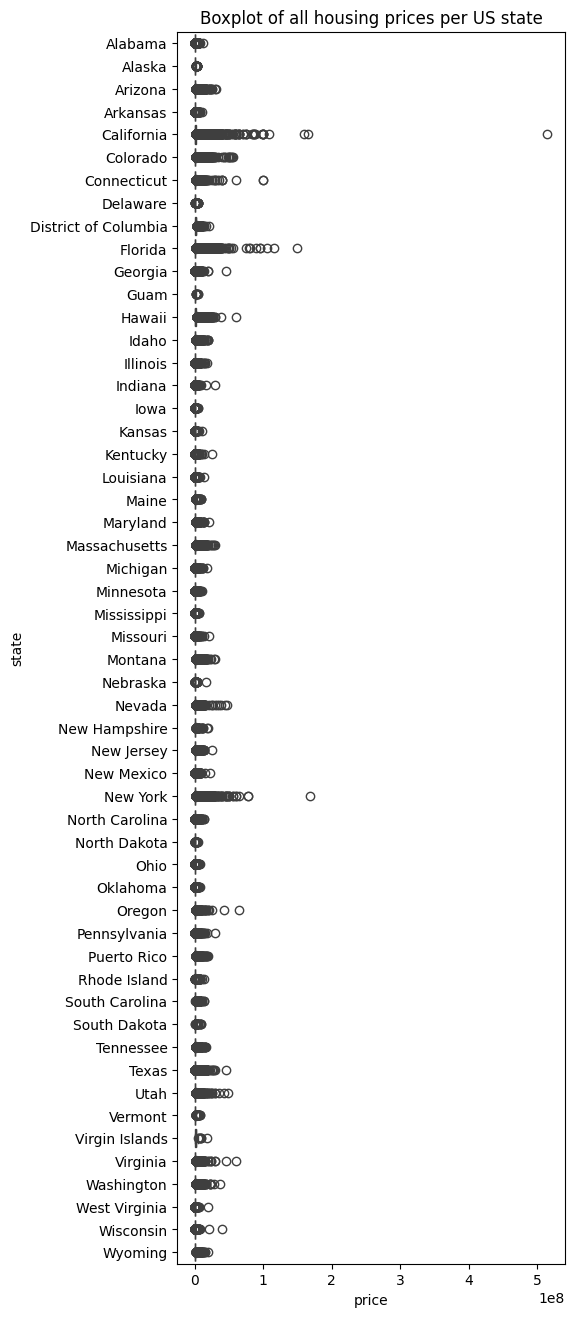

In [ ]:
# here we can see the boxplot of the housing prices in each US state
fig, ax = plt.subplots(1, 1, figsize=(5, 16))
df_temp = df.copy(deep=True)
df_temp['state'] = df_temp['state'].cat.rename_categories({v:k for k,v in usa_state_mapping.items()})
g = sns.boxplot(df_temp, x='price', y='state')
_ = g.set(title="Boxplot of all housing prices per US state")

### Beds and Baths

When analyzing the number of bathrooms and bedroom we can see that there are plenty of outliers.
The graph shows us that most of the houses at most 10 bedrooms/bathrooms, but there are houses that
have more than 400 bedrooms and 200 bathrooms. We will have to minimize the number of outliers in
this dataset for optimal training.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


<Axes: title={'center': 'Boxplot for number of bedrooms'}, xlabel='bed'>

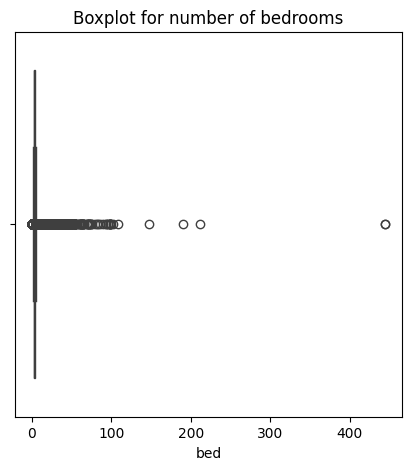

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title("Boxplot for number of bedrooms")
sns.boxplot(df, x='bed', ax=ax)

## Outliers reduction

In [ ]:
from sklearn.ensemble import IsolationForest

df = df.loc[(df['price'] > 1e4) & (df['price'] < 3e6) & (df['acre_lot'] > 0) & (df['house_size'] > 0) & (df['bed'] <= 15)]

iso = IsolationForest(contamination=0.1)
outliers = iso.fit_predict(df[list(set(df.columns) - {'brokered_by', 'street'})])
df['ISO'] = outliers
df


,brokered_by,price,bed,acre_lot,street,state,house_size,prev_sold,for_sale,ISO
0,103378,105000.0,3,0.12,1962661,0,920.0,False,1,-1
1,52707,80000.0,4,0.08,1902874,0,1527.0,False,1,-1
2,103379,67000.0,2,0.15,1404990,0,748.0,False,1,-1
3,31239,145000.0,4,0.10,1947675,0,1800.0,False,1,1
4,103378,179000.0,4,0.46,1850806,0,2520.0,False,1,1
...,...,...,...,...,...,...,...,...,...,...
1360622,23009,359900.0,4,0.33,353094,47,3600.0,True,0,1
1360623,18208,350000.0,3,0.10,1062149,47,1616.0,True,0,1
1360624,76856,440000.0,6,0.50,405677,47,3200.0,True,0,1
1360625,53618,179900.0,2,0.09,761379,47,933.0,True,0,1


In [ ]:
df = df.loc[df['ISO'] == 1]
df.describe()

,brokered_by,price,bed,acre_lot,street,house_size,ISO
count,1.204599e+06,1.204599e+06,1.204599e+06,1.204599e+06,1.204599e+06,1.204599e+06,1204599.0
mean,5.363389e+04,4.216149e+05,3.260915e+00,5.467959e-01,9.272298e+05,1.896276e+03,1.0
std,3.039628e+04,2.857296e+05,8.351795e-01,1.293764e+00,5.343196e+05,7.504215e+02,0.0
min,-1.000000e+00,1.040000e+04,1.000000e+00,1.000000e-02,-1.000000e+00,1.000000e+02,1.0
25%,2.552800e+04,2.299000e+05,3.000000e+00,1.400000e-01,4.618460e+05,1.344000e+03,1.0
50%,5.301600e+04,3.540000e+05,3.000000e+00,2.000000e-01,9.303610e+05,1.752000e+03,1.0
75%,7.922100e+04,5.370000e+05,4.000000e+00,3.700000e-01,1.389117e+06,2.302000e+03,1.0
max,1.101420e+05,2.295000e+06,1.000000e+01,3.509000e+01,2.001143e+06,7.560000e+03,1.0


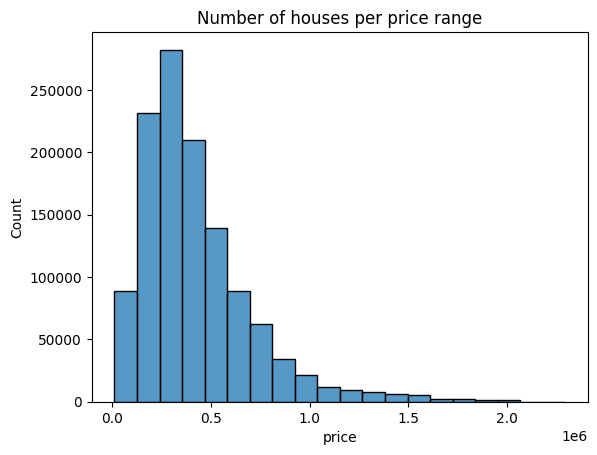

In [ ]:
g = sns.histplot(df, x='price', bins=20)
_ = g.set_title("Number of houses per price range")

<Axes: title={'center': 'Number of houses per bedroom count'}, xlabel='bed', ylabel='Count'>

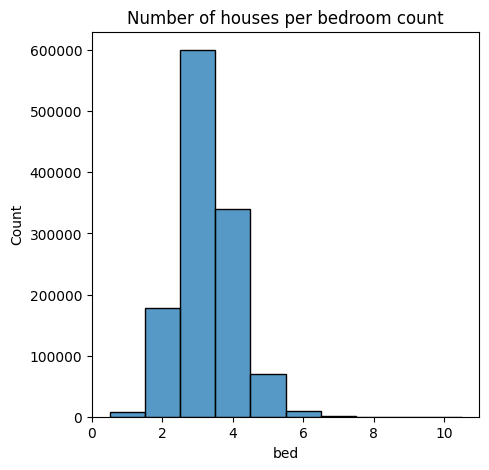

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title("Number of houses per bedroom count")
# ax[1].set_title("Number of houses per bathroom count")
sns.histplot(df, x='bed', ax=ax, discrete=True)
#_ = sns.histplot(df, x='bath', ax=ax[1], discrete=True)

## Create price categories

In [ ]:
# TODO: divide to categories, so that the data range will be pretty even for better training
df2 = df.copy(deep=True)
# bins = [0] + [250000 + i*250000 for i in range(4)] + [df['price'].max()]
# bins = [0, 180000, 270000, 360000, 470000, 650000] + [df['price'].max()]
bins = [0, 270000, 470000] + [df['price'].max()]

# bins = [0, 360000, df['price'].max()]
# labels = [f"{i//1000}K" for i in bins[:-1]]
labels = ["< 270K", "270K - 470K", ">470K"]

df2['bins'] = pd.cut(df2['price'], bins=bins, labels=labels)
# df2['bins'] = pd.qcut(df2['price'], 3)
df2[['price', 'bins']].sort_values('price')

,price,bins
1019697,10400.0,< 270K
81737,10500.0,< 270K
288063,10500.0,< 270K
284749,10500.0,< 270K
1008547,10500.0,< 270K
...,...,...
238495,2250000.0,>470K
214420,2275000.0,>470K
233201,2275000.0,>470K
264437,2275000.0,>470K


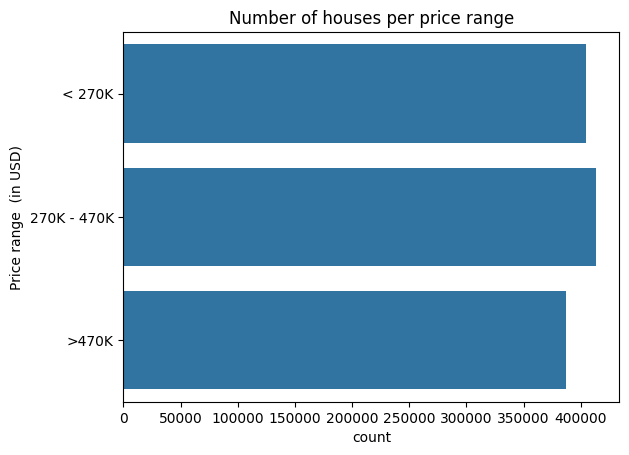

In [ ]:
df_bins = df2.groupby('bins', observed=False).count().unstack()['price']
df_bins = df_bins.reset_index().rename(columns={0: "count"})
g = sns.barplot(df_bins, x='count', y='bins')
_ = g.set_title("Number of houses per price range")
_ = g.set_ylabel("Price range  (in USD)")

In [ ]:
df = df2

In [ ]:
df = df.drop('ISO', axis=1)
df

,brokered_by,price,bed,acre_lot,street,state,house_size,prev_sold,for_sale,bins
3,31239,145000.0,4,0.10,1947675,0,1800.0,False,1,< 270K
4,103378,179000.0,4,0.46,1850806,0,2520.0,False,1,< 270K
5,1205,50000.0,3,0.20,1298094,0,2040.0,False,1,< 270K
10,52707,150000.0,3,0.08,1773902,0,1045.0,False,1,< 270K
14,50739,120000.0,3,0.08,17854,0,1100.0,False,1,< 270K
...,...,...,...,...,...,...,...,...,...,...
1360622,23009,359900.0,4,0.33,353094,47,3600.0,True,0,270K - 470K
1360623,18208,350000.0,3,0.10,1062149,47,1616.0,True,0,270K - 470K
1360624,76856,440000.0,6,0.50,405677,47,3200.0,True,0,270K - 470K
1360625,53618,179900.0,2,0.09,761379,47,933.0,True,0,< 270K


## Finalizing the dataset

In [ ]:
df = df.rename(columns={'bins': 'price_range'})
price_mapping = {st : i for i, st in enumerate(df['price_range'].unique())}
df['price_range'] = df['price_range'].cat.rename_categories(price_mapping)
df = df.drop(['price'], axis=1)
df

,brokered_by,bed,acre_lot,street,state,house_size,prev_sold,for_sale,price_range
3,31239,4,0.10,1947675,0,1800.0,False,1,0
4,103378,4,0.46,1850806,0,2520.0,False,1,0
5,1205,3,0.20,1298094,0,2040.0,False,1,0
10,52707,3,0.08,1773902,0,1045.0,False,1,0
14,50739,3,0.08,17854,0,1100.0,False,1,0
...,...,...,...,...,...,...,...,...,...
1360622,23009,4,0.33,353094,47,3600.0,True,0,1
1360623,18208,3,0.10,1062149,47,1616.0,True,0,1
1360624,76856,6,0.50,405677,47,3200.0,True,0,1
1360625,53618,2,0.09,761379,47,933.0,True,0,0


Text(0.5, 1.0, 'Correlation of the labels')

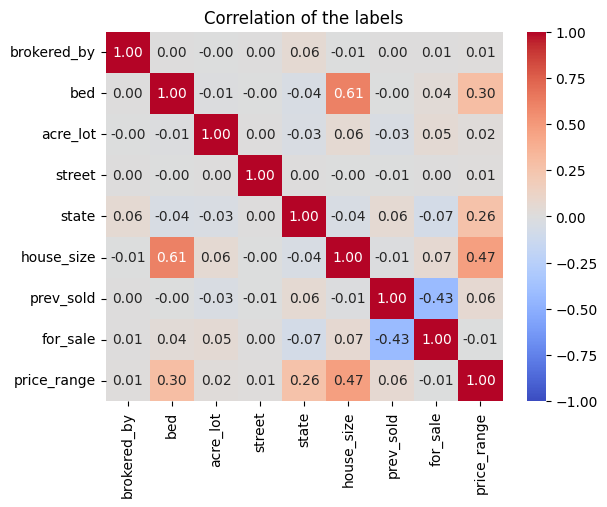

In [ ]:
_g = sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="coolwarm")
_g.set_title("Correlation of the labels")


In [ ]:
_ = """
df['bins'] -> df['price_predict']
df['price_predict'] -> values 0 - n

PCA
correlation matrix

divide the dataset into train, test, validate sets

training:
df_lr = df.copy(deep=True)
X, y
model = ...
model.fit
model.predict
calculate error

till friday, at most sunday
"""

# Logistic Regression

In [ ]:
# 1. Dividing the dataset into training (60 %), testing (20 %) and validation set (20 %).

df_lr = df.copy(deep = True) # Copying the dataset for Logistic Regression
#df_rf['state'] = df_rf['state'].astype('category').cat.rename_categories({v:k for k, v in usa_state_mapping.items()}) # Converting column ['state'] values to categorical data type


X = df_lr[list(set(df_lr.columns) - {"price_range"})] # Input without the ['price'] column
y = df_lr['price_range'] # Output; Column ['price']
X = pd.get_dummies(X, dtype=int) # Converting categorical values to binary values


# Splitting into training and testing sets
X_train_lr, X_temp_lr, y_train_lr, y_temp_lr = train_test_split(X, y, test_size = 0.4, random_state=3)

# Splitting into validation set (should be 20 %)
X_val_lr, X_test_lr, y_val_lr, y_test_lr = train_test_split(X_temp_lr, y_temp_lr, test_size = 1/2, random_state=3)



In [ ]:
# 2. Scaling the data for better performance.
scaler = StandardScaler()
X_train_lr_scaled = scaler.fit_transform(X_train_lr)
X_test_lr_scaled = scaler.transform(X_test_lr)
X_val_lr_scaled = scaler.transform(X_val_lr)

# 3. Initializing a Logistic Regression classifier.
clf_lr = LogisticRegression(solver='saga', max_iter = 100)


In [ ]:
# 4. Training, testing and validating the model.

clf_lr.fit(X_train_lr_scaled, y_train_lr) # Training on the training set
y_test_pred_lr = clf_lr.predict(X_test_lr_scaled) # Testing on the testing dataset
y_val_pred_lr = clf_lr.predict(X_val_lr_scaled) # Validating on the validation set

In [ ]:
# 5. Calculating the accuracy of Logistic Regression model
accuracy_test_lr = accuracy_score(y_test_lr, y_test_pred_lr) # Accuracy of the testing set
accuracy_val_lr = accuracy_score(y_val_lr, y_val_pred_lr) # Accuracy of the validation set

print('Accuracy of the model on testing set:', accuracy_test_lr)
print('Accuracy of the model on validation set:', accuracy_val_lr)

# No scaling and solver = saga
# --> Got accuracy_test = 0,43 and accuracy_val = 0,43

# Scaled and solver = saga
# --> Got accuracy_test = 0,67 and accuracy_val = 0,67

Accuracy of the model on testing set: 0.673567989374066
Accuracy of the model on validation set: 0.6745807737008136


# Random Forest

In [ ]:

df_rf = df.copy(deep=True)
df_rf['state'] = df_rf['state'].astype('category').cat.rename_categories({v:k for k, v in usa_state_mapping.items()})
y = df_rf['price_range']
X = df_rf[list(set(df_rf.columns) - {"price_range"})]
X = pd.get_dummies(X, dtype=int)


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state=3)


In [ ]:

estimators = [i for i in range(150, 201, 10)]
train_acc = []
test_acc = []
conf_mats_train = []
conf_mats_test = []

for i in estimators:
  print(i)
  clf = RandomForestClassifier(n_estimators=i)
  clf.fit(X_train, y_train)
  y_pred_train = clf.predict(X_train)
  acc = accuracy_score(y_train, y_pred_train)
  train_acc.append(acc)
  conf_mats_train.append(confusion_matrix(y_train, y_pred_train))

  y_pred = clf.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  test_acc.append(acc)
  conf_mats_test.append(confusion_matrix(y_test, y_pred))



150
160
170
180
190
200


0.7078656815540428

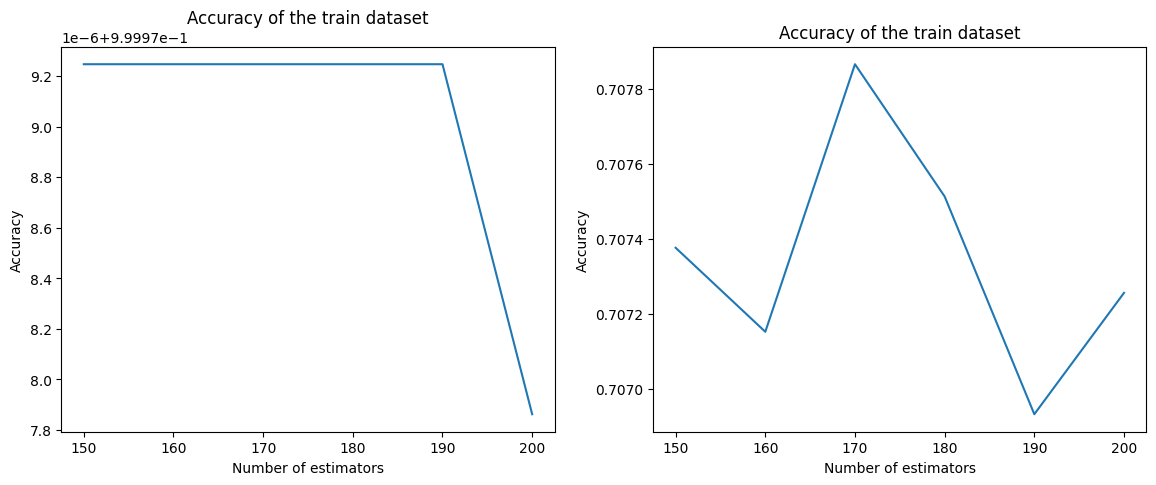

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].set_title("Accuracy of the train dataset")
ax[1].set_title("Accuracy of the test dataset")

ax[0].plot(estimators, train_acc)
ax[0].set(**{'title': 'Accuracy of the train dataset', 'xlabel': 'Number of estimators', 'ylabel': 'Accuracy'})
ax[1].plot(estimators, test_acc)
ax[1].set(**{'title': 'Accuracy of the train dataset', 'xlabel': 'Number of estimators', 'ylabel': 'Accuracy'})
max(test_acc)


Accuracy: 0.7078656815540428


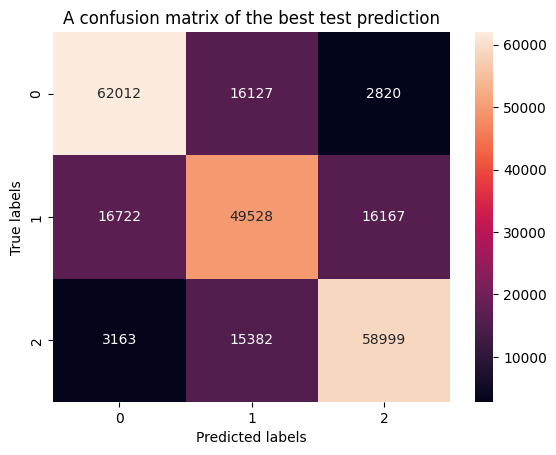

In [ ]:
confmat = conf_mats_test[2]
acc = test_acc[2]

print("Accuracy:", acc)

# plot the confusion matrix
ax = plt.subplot()
sns.heatmap(confmat,annot=True, fmt='g', ax=ax)
ax.set(**{
    'xlabel': 'Predicted labels',
    'ylabel': 'True labels',
    'title': 'A confusion matrix of the best test prediction'
})
plt.show()

0.7078698323094803


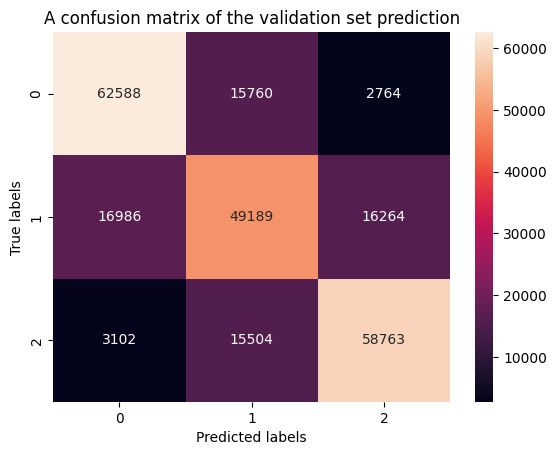

In [ ]:
clf = RandomForestClassifier(n_estimators=170)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(acc)

confmat = confusion_matrix(y_val, y_pred)
ax = plt.subplot()
sns.heatmap(confmat,annot=True, fmt='g', ax=ax)
ax.set(**{
    'xlabel': 'Predicted labels',
    'ylabel': 'True labels',
    'title': 'A confusion matrix of the validation set prediction'
})
plt.show()
